# Création d'un RAG

## Récolte des données et préparation des chunks:

In [1]:
import re
from bs4 import BeautifulSoup
import requests


ai_act_url = "https://eur-lex.europa.eu/legal-content/FR/TXT/HTML/?uri=OJ:L_202401689"
soup = BeautifulSoup(requests.get(ai_act_url).content, "html.parser")
text = []
context = []
section_type = []
url = []
url_sections = []
url_chapitres = []


&emsp;La préparation des données et métadonnées se fait ici à l'aide de **BeautifulSoup** et non pas les [**document loaders de LangChain**] (https://python.langchain.com/docs/how_to/#document-loaders) car il nous faut plus de contrôle sur la façon dont on sélectionne l'AI Act.

&emsp; On cherche à le sélectionner en fonction de ses *Considérants*, *Chapitres*, *Sections* et *Articles*.

Chacun de ces éléments sera accompagné de métadonnées telles qu'un lien à la section, le nom du chapitre et de l'article.

In [ ]:
# Préambule
considerants = soup.find_all("div", {"class":"eli-subdivision", "id": re.compile(r'rct_\d+')})
text += [considerant.text.strip() for considerant in considerants]
context += [f"Considérant {n+1}" for n in range(len(considerants))]
url += [ai_act_url+f"#rct_{n+1}" for n in range(len(considerants))]
url_sections += [None for _ in range(len(considerants))]
url_chapitres += [ai_act_url+"#pbl_1" for _ in range(len(considerants))]
section_type += ["considerant"]*len(considerants)

In [ ]:
# Chapitre
chapitres = soup.find("div", {"id": "enc_1"}).find_all("div", {"id": re.compile(r'cpt_[XVILC]+')}, recursive=False)
articles = []

def get_article_and_article_str(soup_element: BeautifulSoup):
    _articles = soup_element.find_all("div", {"class":"eli-subdivision", "id": re.compile(r'art_\d+')})
    article_strs = [
        f"Art.{article['id'].strip('art_')}-"+article.find("div", {"class": "eli-title"}).text for
        article in _articles
    ]
    return _articles, article_strs

for idx_ch, chapitre in enumerate(chapitres):
    chapitre_url = ai_act_url+f"#{chapitre['id']}"
    chapitre_str = f"Ch.{idx_ch+1}-"+chapitre.find("p", {"class": "oj-ti-section-2"}).text.strip("\n")+" > "
    chapitre_articles =  chapitre.find_all("div", {"class":"eli-subdivision", "id": re.compile(r'art_\d+')})
    url_chapitres += [chapitre_url for _ in range(len(chapitre_articles))]
    text += [article.text.strip() for article in chapitre_articles]
    
    section_str = ""
    sections = chapitre.find_all("div", {"id":re.compile(r'cpt_[XVILC]+.sct_\d+')}, recursive=False)
    
    if sections:
        for idx_sct, section in enumerate(sections):
            _articles, article_strs = get_article_and_article_str(section)
            articles += _articles
            url_sections += [ai_act_url+f"#{section['id']}" for _ in range(len(_articles))]
            section_str = f"Sct.{idx_sct+1}-"+section.find("p", {"class": "oj-ti-section-2"}).text.strip("\n")+" > "
            context += [chapitre_str+section_str+article_str for article_str in article_strs]
    else:
        _articles, article_strs = get_article_and_article_str(chapitre)
        articles += _articles
        context += [chapitre_str+article_str for article_str in article_strs]
        url_sections += [None for _ in range(len(_articles))]
section_type += ["article"]*len(articles)
url += [ai_act_url+f"#art_{n}" for n in range(1,len(articles)+1)]

In [ ]:
# Annexe
annexes = soup.find_all("div", {"class": "eli-container", "id": re.compile(r'anx_[XVILC]+')})
titres_annexes = [annexe.find("p", {"class": "oj-doc-ti", "id":None}).get_text() for annexe in annexes]

text += [annexe.text.strip() for annexe in annexes]
context += titres_annexes
section_type += ["annexe"]*len(articles)
url += [ai_act_url+f"#{annexe['id']}" for annexe in annexes]
url_sections += [None for _ in range(len(annexes))]
url_chapitres += [ai_act_url+"#anx_I" for _ in range(len(annexes))]

texts = [f"{context[idx]} \n {text[idx]}" for idx in range(len(text))]
metadatas = [ 
    {
        "titre":context[idx],
        "nature": section_type[idx],
        "url":url[idx],
        "url_chapitre": url_chapitres[idx],
        "url_section": url_sections[idx]
    }
    for idx in range(len(texts))
]

## Préparation des Documents et des chunks avec[RecursiveCharaterTextSplitter](https://python.langchain.com/docs/how_to/recursive_text_splitter/). 

&emsp;La sélection de la taille des chunks et leur overlap peut avoir un impact significatif sur la performance de la recherche vectorielle par la suite et donc de la performance du RAG par derrière. 

&emsp;Ce [guide](https://www.machinelearningplus.com/gen-ai/optimizing-rag-chunk-size-your-definitive-guide-to-better-retrieval-accuracy/#:~:text=Optimal%20chunk%20size%20for%20RAG%20systems%20typically%20ranges,tokens%29%20provide%20better%20context%20for%20complex%20reasoning%20tasks.) donne une idée de structure d'évaluation pour déterminer les bons paramètres.

&emsp;A titre d'exemple, on va utiliser des chunks de 256 characters avec un overlap de 10%. Une petite taille de chunk fera de notre RAG un outil paré pour répondre à des questions factuelles.

In [9]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1024, chunk_overlap = int(256*0.1), length_function=len
)

text_chunks: list[Document] = text_splitter.create_documents(texts=texts, metadatas=metadatas)

## Création d'une base vectorielle. 

### Sur une ressource Azure AI Search

#### Préparation des champs de la base vectorielle
&emsp;Lors de la création d'une base vectorielle, il faut au préalable définir les champs de celle-ci ainsi que leur propriété. 

On peut notamment indiquer:
- quels champs sont récupérables
- sur lesquels peut-on trier la base
- sur lesquels peut-on la filtrer

&emsp;Dans cet exemple, on ajoute le champ **nature** qui est tiré des **métadonnées** (si un champ est défini avec un nom tiré d'une clé des métadonnées, les valeurs de cette dernière y seront inscrites). On pourra par la suite filtrer notre recherche si on souhaite avoir des résultats ne comprenant uniquement des *article*, des *considérant* ou des *annexe*.

In [4]:
from langchain_community.vectorstores.azuresearch import AzureSearch
from azure.search.documents.indexes.models import SimpleField, SearchFieldDataType, SearchableField, SearchField
from dotenv import load_dotenv
from globals import EMBEDDINGS
import os
load_dotenv()

# Attention, un champ qui est filtrable va agrandir la taille de l'index créé.
fields = [
    SimpleField(name="id", type=SearchFieldDataType.String, key=True, sortable=True, filterable=True,),
    SearchableField(name="content", type=SearchFieldDataType.String, searchable=True),
    SearchField(name="content_vector", type=SearchFieldDataType.Collection(SearchFieldDataType.Single), vector_search_dimensions=1536, vector_search_profile_name="myHnswProfile", searchable=True),
    SearchableField(name="metadata", type=SearchFieldDataType.String, searchable=True, filterable=True),
    SearchableField(name="nature", type=SearchFieldDataType.String, searchable=True, filterable=True),
]

# Création ou Instanciation de la base vectorielle. Si l'index n'existe pas, il sera créé puis il pourra être utilisé via la variable vector_store,
vector_store = AzureSearch(
    azure_search_endpoint=os.environ["SEARCH_ENDPOINT"],
    azure_search_key=os.environ["SEARCH_KEY"],
    index_name=os.environ["SEARCH_INDEX"],
    embedding_function=EMBEDDINGS.embed_query,
    additional_search_client_options={"retry_total": 4},
    fields=fields
)

# Si l'index vient d'être créé, il faut alors y ajouter les chunks créés auparavant.
# vector_store.add_documents(text_chunks)

##### Testez la recherche sémantique

In [17]:
search_docs = vector_store.similarity_search(query="Service payant", k=5)
print("\n\n".join(search_doc.page_content for search_doc in search_docs))

Ch.13-DISPOSITIONS FINALES > Art.111-
Systèmes d’IA déjà mis sur le marché ou mis en service et modèles d’IA à usage général déjà mis sur le marché
 
 Article 111

Systèmes d’IA déjà mis sur le marché ou mis en service et modèles d’IA à usage général déjà mis sur le marché


1.   Sans préjudice de l’application de l’article 5 visée à l’article 113, paragraphe 3, point a), les systèmes d’IA qui sont des composants des systèmes d’information à grande échelle établis par les actes juridiques énumérés à l’annexe X et mis sur le marché ou mis en service avant le 2 août 2027 sont mis en conformité avec le présent règlement au plus tard le 31 décembre 2030.
Il est tenu compte des exigences énoncées dans le présent règlement lors de l’évaluation de chaque système d’information à grande échelle établi par les actes juridiques énumérés à l’annexe X devant être effectuée conformément à ces actes juridiques et lorsque ces actes juridiques sont remplacés ou modifiés.

en soi, constituer une monétis

### Sur une base locale

Si vous n'avez pas d'accès Azure, il est également possible de créer des bases vectorielles localement avec des modèles de vectorisation et un modèle LLM gratuit.

- [Vector Stores](https://python.langchain.com/docs/integrations/vectorstores/)
- [Embedding Models](https://python.langchain.com/docs/integrations/text_embedding/)
- [Chat Models](https://python.langchain.com/docs/integrations/chat/)

#### Appel Programmatique à un LLM
Pour faire appel à un LLM, Langchain propose des classes spécifiques à chaque LLM(eg Anthropic, OpenAI, [AzureOpenAI](https://python.langchain.com/docs/integrations/chat/azure_chat_openai/#model-features)).

Celles-ci peuvent être instanciées à l'aide des clés API et endpoints nécessaires (voir la doc Langchain pour plus de détails).

Comme dit dans le README, on va utiliser les variables du.env pour instantaner une classe de chat complétion AzureOpenAI

In [7]:
from langchain_openai import AzureChatOpenAI
from langchain_core.documents import Document
from langchain_core.rate_limiters import InMemoryRateLimiter
from dotenv import load_dotenv
load_dotenv()

rate_limiter = InMemoryRateLimiter(
        requests_per_second=10,
        check_every_n_seconds=0.1,
        max_bucket_size=10
    )

llm = AzureChatOpenAI(
    azure_endpoint=os.environ["AZURE_OPENAI_API_ENDPOINT"],
    azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
    api_key=os.environ["AZURE_OPENAI_API_KEY"],
    rate_limiter=rate_limiter,
    streaming=True,
    seed=42
)

llm.invoke("Write me a Haiku").content

'Whispers in the breeze,  \nLeaves dance under autumn skies,  \nTime drifts gently by.'

#### Conception de Prompts via les [Templates LangChain](https://python.langchain.com/docs/concepts/prompt_templates/)

##### Définition du format des promptes

Afin de proprement définir le comportement d'une application LLM, les **PropmtTemplate** permettent de structurer les instructions et questions ingéré par le modèle.

Ici notre prompte doit tenir compte de la question utilisateur et du contexte renvoyé par la base vectorielle.

In [5]:
from langchain_core.prompts import HumanMessagePromptTemplate, PromptTemplate, ChatPromptTemplate

setup_prompt = ChatPromptTemplate(
    input_variables=['context', 'question'],
    messages=[
        HumanMessagePromptTemplate(
            prompt=PromptTemplate(
                input_variables=['context', 'question'], 
                input_types={}, 
                partial_variables={}, 
                template="""
                Tu est un expert legal qui conseil l'utilisateur sur toute question en lien avec l'AI Act. 
                
                En te basant sur le context suivant, répond à la question.  
                Si il n'y à pas de context fourni ou que sont rapport à la question est marginal, précède ta réponse par la note suivante:

                "Ma base de connaissance semble limité pour répondre à votre question, les éléments de réponse suivant doivent être pris avec des pincettes !" 

                \nQuestion: {question}
                \nContext: {context} 
                \Réponse:"""
            ), additional_kwargs={}
        )
    ]
)

<>:21: SyntaxWarning: invalid escape sequence '\R'
<>:21: SyntaxWarning: invalid escape sequence '\R'
C:\Users\HugoRECHATIN\AppData\Local\Temp\ipykernel_20008\3306373742.py:21: SyntaxWarning: invalid escape sequence '\R'
  \Réponse:"""


#### State Graph

Le **StateGraph** de [**LangGraph**](https://langchain-ai.github.io/langgraph/?_gl=1*q59ke1*_gcl_au*MTM1MDQ3OTk4OS4xNzUwODU3NDI4*_ga*NjYwNjA0NDQ4LjE3NDU0MTg0NTA.*_ga_47WX3HKKY2*czE3NTE2MzkyMTUkbzU0JGcxJHQxNzUxNjM5MjE1JGo2MCRsMCRoMA..) sert à coordonner les requêtes et réponses du *LLM* et du *Retriver*.

Les StateGraph sont des machines d'états avec lesquelles on peut agencer les différents appels LLM en fonction d'une séquence d'états. Chaque État va exécuter un code et modifier les valeurs de l'état.

La séquence ainsi définie permet d'assurer que les appels LLM ne s'empiètent pas.

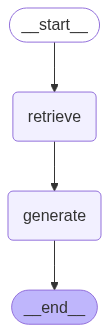

In [8]:
from typing_extensions import List, TypedDict
from langgraph.graph import START, StateGraph
from langchain_community.vectorstores.azuresearch import AzureSearchVectorStoreRetriever
from IPython.display import Image, display

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

retriever: AzureSearchVectorStoreRetriever = vector_store.as_retriever()

def retrieve(state: State):   
    """Appel vers la base vectorielle """
    retrieved_docs = retriever.invoke(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n".join(doc.page_content for doc in state["context"])
    messages = setup_prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
rag = graph_builder.compile()

# On peut obtenir un schémas de notre machine d'états grâce à la ligne suivante.
display(Image(rag.get_graph().draw_mermaid_png()))

#### Tester le RAG
On peut utiliser le stream avec le mode **update** afin d'observer la progression de nos requêtes à travers le graphe d'états.

In [27]:
for step in rag.stream(
    {"question": "Quels articles address l'application d'algorithme de reconnaissance facial ?"},
    stream_mode="updates"
):
    print(step)

{'retrieve': {'context': [Document(metadata={'id': 'NmI3NzM5ZTctODdlYy00NzlhLWE2YjQtMTE1ZjBjNjZmMzFi', 'titre': 'Ch.4-OBLIGATIONS DE TRANSPARENCE POUR LES FOURNISSEURS ET LES DÉPLOYEURS DE CERTAINS SYSTÈMES D’IA > Art.50-\nObligations de transparence pour les fournisseurs et les déployeurs de certains systèmes d’IA\n', 'nature': 'article', 'url': 'https://eur-lex.europa.eu/legal-content/FR/TXT/HTML/?uri=OJ:L_202401689#art_50', 'url_chapitre': 'https://eur-lex.europa.eu/legal-content/FR/TXT/HTML/?uri=OJ:L_202401689#cpt_IV', 'url_section': None}, page_content='3.\xa0\xa0\xa0Les déployeurs d’un système de reconnaissance des émotions ou d’un système de catégorisation biométrique informent les personnes physiques qui y sont exposées du fonctionnement du système et traitent les données à\xa0caractère personnel conformément au règlement (UE) 2016/679, au règlement (UE) 2018/1725 et à\xa0la directive (UE) 2016/680, selon le cas. Cette obligation ne s’applique pas aux systèmes d’IA utilisés pou

In [28]:
print(rag.invoke({"question": "Selon l'ai act est il légale d'utilisé un modéle de reconnaissance facial et si oui dans quelles circonstance. Répond avec les citation aux informations donné par le context."})["answer"])

Selon le contexte fourni, l'utilisation des systèmes de reconnaissance faciale sous le cadre de l'AI Act est soumise à des restrictions strictes et ne peut être considérée comme légale que dans des circonstances spécifiques. Voici les principaux points tirés du contexte :

1. **Obligation d'information et conformité aux règlements** :
   Les déployeurs de systèmes de reconnaissance faciale doivent informer les personnes exposées au fonctionnement de ces systèmes. En outre, ils doivent traiter les données personnelles conformément aux réglementations en vigueur, notamment le **Règlement Général sur la Protection des Données (RGPD)** (UE 2016/679), le règlement (UE) 2018/1725 et la directive (UE) 2016/680 concernant les données personnelles.

   Cependant, cette obligation **ne s'applique pas aux systèmes utilisés dans un cadre légal** à des fins de prévention ou détection des infractions pénales, ou pour des enquêtes en la matière. Dans ce cas, des garanties appropriées doivent être pré

#### Prochaines étapes:
Pour les prochains points, consultez les fichiers rag_chat.py et rag_simple.py 
- Ajouter un **analyste de question utilisateurs** pour les convertir en requêtes de recherche vectorielle pertinentes. 
- Formater les réponses du RAG de sorte à ce que les liens vers les sections de l'ai act y soient cliquables
- Créer une application chat standard via Streamlit
- Ajouter une fenêtre contextuelle pour que les questions puissent référencer la chaîne de messages.

#### rag_simple

In [1]:
from rag_simple import get_compiled_rag
from IPython.display import Image, display

rag_simple = get_compiled_rag()

#### rag_chat

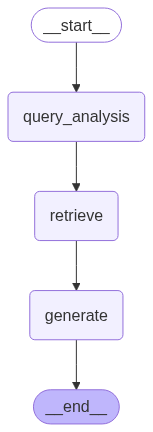

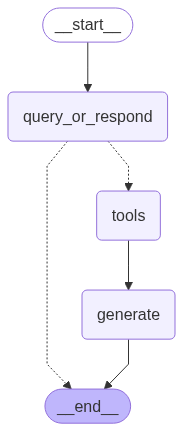

In [2]:
from rag_chat import get_compiled_rag

rag_chat = get_compiled_rag()

display(Image(rag_simple.get_graph().draw_mermaid_png()), Image(rag_chat.get_graph().draw_mermaid_png()))

On peut voir en comparant les 2 graphs que d'un côté, chaque étape du RAG doit être traversée lorsqu'un utilisateur lance une requête au **rag_simple** alors que avec le **rag_chat**, l'état query_or_respond peut directement répondre si la réponse ne concerne pas l'AI Act ou si elle concerne des messages en mémoire.

Vu que le rag_chat est composé d'une chaîne de **messages LangChaines**, on peut streamer la réponse à notre requête en utilisant BaseMessage.pretty_print

In [3]:
from time import time
config = {"configurable": {"thread_id": f"{time()}"}}
for step in rag_chat.stream(
    {
        "messages":[
            {"role": "user", "content": "Quels annexes address l'application d'algorithme de reconnaissance facial ?"}
        ]
    },
    stream_mode="values",
    config=config
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Quels annexes address l'application d'algorithme de reconnaissance facial ?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_A5VnaT9nPpaR5UoBGpeAcUK5)
 Call ID: call_A5VnaT9nPpaR5UoBGpeAcUK5
  Args:
    question: Quels annexes address l'application d'algorithme de reconnaissance facial ?
================================= Tool Message =================================
Name: retrieve

Source: {'id': 'MmIxZTJjZDUtOGIxNi00NWQyLTkxODgtMDExYWUxNmExNGMy', 'titre': "Systèmes d'IA à\xa0haut risque visés à\xa0l'article\xa06, paragraphe\xa02", 'nature': 'annexe', 'url': 'https://eur-lex.europa.eu/legal-content/FR/TXT/HTML/?uri=OJ:L_202401689#anx_III', 'url_chapitre': 'https://eur-lex.europa.eu/legal-content/FR/TXT/HTML/?uri=OJ:L_202401689##anx_I', 'url_section': None}Content: Systèmes d'IA à haut risque visés à l'article 6, paragraphe 2 
 ANNEXE III
Systèm